In [1]:
# Building makemore Part 5: Building a WaveNet(https://youtu.be/t3YJ5hKiMQ0?si=c1Cp6N-Xzbn8DKLL)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the volcabulary
chars = [chr(ord('a') + c) for c in range(26)]
stoi = {s:i + 1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
#shuffle the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
#build the data set
block_size = 8 #context lenght for a prediction
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.' :
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words)) # first 80% is the training set
n2 = int(0.9*len(words)) # next 10% is the dev set and the rest is the test set
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
for x,y in zip(Xtr[:20],Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [8]:
# layers

class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters(trained)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers(updated with the momentum, used in predictions)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim = True)
            xvar = x.var(dim, keepdim = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        #update buffers:
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + xmean * self.momentum
                self.running_var = (1 - self.momentum) * self.running_var + xvar * self.momentum
        return self.out

    def parameters(self):
            return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embeddings_dim):
        self.weight = torch.rand((num_embeddings, embeddings_dim))

    def __call__(self, Xi):
        self.out = self.weight[Xi]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

# containers

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        self.out = x
        return self.out

    def parameters(self):
            return [p for layer in self.layers for p in layer.parameters()]

In [9]:
torch.manual_seed(42)

In [10]:
n_embd = 10 # the number of dimmensions for the embedding
n_hidden = 68 # number of neurons in the hidden layer

model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

#param init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # decrese confidence in the last layer

parameters = model.parameters()
print(f'num parameters = {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

num parameters = 22397


In [11]:
#training
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    #construct batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward
    for p in parameters:
        p.grad = None

    loss.backward()

    #update learning rate decay
    lr = 0.1 if i < 150_000 else 0.01
    
    #update params
    for p in parameters:
        p.data += -lr * p.grad

    #stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3150
  10000/ 200000: 2.0839
  20000/ 200000: 1.9275
  30000/ 200000: 1.8560
  40000/ 200000: 1.6994
  50000/ 200000: 2.2555
  60000/ 200000: 2.0314
  70000/ 200000: 2.0925
  80000/ 200000: 2.0370
  90000/ 200000: 2.1443
 100000/ 200000: 1.9475
 110000/ 200000: 2.2459
 120000/ 200000: 2.4110
 130000/ 200000: 1.7355
 140000/ 200000: 2.4736
 150000/ 200000: 1.8237
 160000/ 200000: 1.6575
 170000/ 200000: 2.2430
 180000/ 200000: 1.7766
 190000/ 200000: 1.5780


In [12]:
for l in model.layers:
    print(l.__class__.__name__, l.out.shape)

Embedding torch.Size([32, 8, 10])
FlattenConsecutive torch.Size([32, 4, 20])
Linear torch.Size([32, 4, 68])
BatchNorm1d torch.Size([32, 4, 68])
Tanh torch.Size([32, 4, 68])
FlattenConsecutive torch.Size([32, 2, 136])
Linear torch.Size([32, 2, 68])
BatchNorm1d torch.Size([32, 2, 68])
Tanh torch.Size([32, 2, 68])
FlattenConsecutive torch.Size([32, 136])
Linear torch.Size([32, 68])
BatchNorm1d torch.Size([32, 68])
Tanh torch.Size([32, 68])
Linear torch.Size([32, 27])


In [13]:
for l in model.layers:
    l.training = False

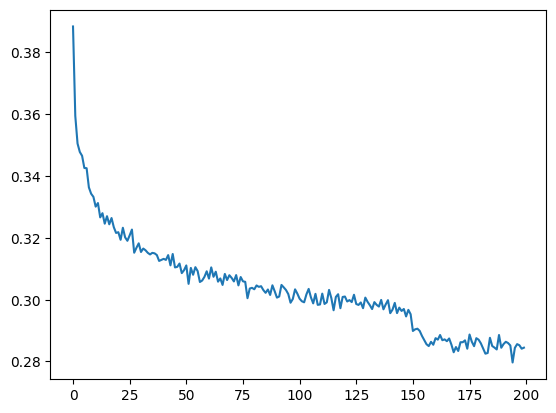

In [14]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [15]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 1.910190224647522
dev 2.0098516941070557


In [16]:
# sample

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break;

    print(''.join(itos[ix] for ix in out))
        

suynor.
kyvin.
whalins.
nyyva.
fara.
nelia.
kashfyn.
tolverca.
elext.
lantri.
naimal.
rick.
melasii.
kay.
sifrabe.
zhyonak.
erishi.
ciennah.
johnamai.
jerman.
